<a href="https://colab.research.google.com/github/SVNasonkova/portfolio_python/blob/main/netflix_users_analysis/netflix_users_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Цель исследования

Целью данного исследования является анализ пользовательской базы Netflix для выявления ключевых характеристик пользователей, понимания их поведения и определения факторов, влияющих на тип подписки и выручку сервиса.

# Загрузка и предобработка

## Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Данные взяты с сайта kaggle
[пользователи Netflix](https://www.kaggle.com/datasets/arnavsmayan/netflix-userbase-dataset)

In [ ]:
# Импорты и настройки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from datetime import datetime
import warnings
df_primary = pd.read_csv('/content/drive/MyDrive/Zerocode/PN14/netflix_users_data.csv')

In [ ]:
df_primary.head()

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
0,1,Basic,10,15-01-22,10-06-23,United States,28,Male,Smartphone,1 Month
1,2,Premium,15,05-09-21,22-06-23,Canada,35,Female,Tablet,1 Month
2,3,Standard,12,28-02-23,27-06-23,United Kingdom,42,Male,Smart TV,1 Month
3,4,Standard,12,10-07-22,26-06-23,Australia,51,Female,Laptop,1 Month
4,5,Basic,10,01-05-23,28-06-23,Germany,33,Male,Smartphone,1 Month


## Приведение столбцов к стилю camel_case

In [ ]:
def to_camel_case(snake_case_string):
    """Преобразует строку в snake_case."""
    components = snake_case_string.split('_')
    # Делаем первую букву каждого слова, кроме первого, заглавной
    return components[0] + ''.join(x.title() for x in components[1:])

def rename_columns_to_camel_case(df_primary):
    """Переименовывает столбцы DataFrame в camelCase."""
    new_columns = {col: to_camel_case(col) for col in df_primary.columns}
    return df_primary.rename(columns=new_columns)

# Заменим пробелы, скобки и дефисы в названиях столбцов на подчеркивания, чтобы их можно было правильно конвертировать в camelCase
df_primary.columns = df_primary.columns.str.replace(' ', '_')
df_primary.columns = df_primary.columns.str.replace(r'[\(\)]', '', regex=True)
df_primary.columns = df_primary.columns.str.replace('-', '_')

# Применим функцию переименования
df_camel_case = rename_columns_to_camel_case(df_primary)

#Сделаем первую букву каждого столбца строчной в df_camel_case
df_camel_case.columns = [col[0].lower() + col[1:] if len(col) > 0 else col for col in df_camel_case.columns]

# Выведем DataFrame с новыми названиями столбцов
print(df_camel_case.columns)

Index(['userId', 'subscriptionType', 'monthlyRevenue', 'joinDate',
       'lastPaymentDate', 'country', 'age', 'gender', 'device',
       'planDuration'],
      dtype='object')


In [ ]:
# Создание переменной df для дальнейшей работы с данными
df = df_camel_case

## Приведение типов данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   userId            2500 non-null   int64 
 1   subscriptionType  2500 non-null   object
 2   monthlyRevenue    2500 non-null   int64 
 3   joinDate          2500 non-null   object
 4   lastPaymentDate   2500 non-null   object
 5   country           2500 non-null   object
 6   age               2500 non-null   int64 
 7   gender            2500 non-null   object
 8   device            2500 non-null   object
 9   planDuration      2500 non-null   object
dtypes: int64(3), object(7)
memory usage: 195.4+ KB


Типы данных столбцов соответствуют их содержимому, за исключением столбцов `joinDate` и `lastPaymentDate`, которые в данный момент имеют тип `object` и требуют преобразования в формат даты (`datetime`).

In [ ]:
# Безопасное преобразование столбцов с датами в формат datetime.
# Сначала пытаемся использовать формат с днем в начале (dayfirst=True).
# Если парсинг не удался (генерируются ошибки), заменяем ошибочные значения на NaT (Not a Time).
# Это более безопасный подход, чем явное указание формата, который может не подходить ко всем датам.
for col in ['joinDate','lastPaymentDate']:
    if col in df.columns:
        # Попытка преобразования с dayfirst=True, ошибки преобразуются в NaT
        df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
        # Если после первой попытки осталось много пропущенных значений (NaT),
        # возможно, даты имеют другой формат (например, год в начале).
        # Попробуем стандартный парсинг без dayfirst=True (pandas автоматически определяет формат),
        # также с преобразованием ошибок в NaT.
        if df[col].isna().mean() > 0.01: # Проверяем, если доля NaT более 1%
            df[col] = pd.to_datetime(df[col], errors='coerce')  # Повторная попытка парсинга

# Вывод типов данных столбцов с датами для проверки успешности преобразования.
print(df[['joinDate','lastPaymentDate']].dtypes)
# Вывод количества пропущенных значений (NaT) в столбцах с датами.
print('Количество пропущенных дат (NaT) в joinDate и lastPaymentDate соответственно:', df['joinDate'].isna().sum(), df['lastPaymentDate'].isna().sum())

joinDate           datetime64[ns]
lastPaymentDate    datetime64[ns]
dtype: object
Количество пропущенных дат (NaT) в joinDate и lastPaymentDate соответственно: 0 0


## Поиск дублей и пропусков в данных

In [ ]:
# Проверяем уникальные значения и нормализуем регистр/пробелы
cat_cols = ['subscriptionType','country','gender','device','planDuration']
for c in cat_cols:
    if c in df.columns:
        # Удаляем пробелы в начале и конце строки
        df[c] = df[c].astype(str).str.strip()
        df[c] = df[c].replace({'nan': np.nan})  # если как строка
        # привести к Title case для читаемости
        df[c] = df[c].str.title()
        print(c, ':', df[c].nunique(), 'пример:', df[c].unique()[:10])

subscriptionType : 3 пример: ['Basic' 'Premium' 'Standard']
country : 10 пример: ['United States' 'Canada' 'United Kingdom' 'Australia' 'Germany' 'France'
 'Brazil' 'Mexico' 'Spain' 'Italy']
gender : 2 пример: ['Male' 'Female']
device : 4 пример: ['Smartphone' 'Tablet' 'Smart Tv' 'Laptop']
planDuration : 1 пример: ['1 Month']


In [ ]:
# Дубликаты
print('Полные дубликаты строк:', df.duplicated().sum())
if 'userId' in df.columns:
    print('Всего userId:', len(df), 'уникальных userId:', df['userId'].nunique())
    # если userId не уникален — показать примеры
    dup_ids = df['userId'][df['userId'].duplicated()].unique()
    print('Примеры повторяющихся userId (до 10):', dup_ids[:10])

Полные дубликаты строк: 0
Всего userId: 2500 уникальных userId: 2500
Примеры повторяющихся userId (до 10): []


На основании этих результатов можно сделать вывод, что очистка данных от дубликатов и пропусков не требуется.

# Исследовательский анализ данных

## Количество уникальных пользователей и период, с которого появились эти пользователи.

In [ ]:
df.head()

,userId,subscriptionType,monthlyRevenue,joinDate,lastPaymentDate,country,age,gender,device,planDuration,joinMonthYear,subscriptionDurationMonths,totalRevenue,ageGroup
0,1,Basic,10,2022-01-15,2023-06-10,United States,28,Male,Smartphone,1 Month,2022-01,18,180,25-34
1,2,Premium,15,2021-09-05,2023-06-22,Canada,35,Female,Tablet,1 Month,2021-09,22,330,25-34
2,3,Standard,12,2023-02-28,2023-06-27,United Kingdom,42,Male,Smart Tv,1 Month,2023-02,5,60,35-44
3,4,Standard,12,2022-07-10,2023-06-26,Australia,51,Female,Laptop,1 Month,2022-07,12,144,45-54
4,5,Basic,10,2023-05-01,2023-06-28,Germany,33,Male,Smartphone,1 Month,2023-05,2,20,25-34


In [ ]:
# сколько уникальных пользователей?
unique_users = df['userId'].nunique()
print(f"Количество уникальных пользователей: {unique_users}")

Количество уникальных пользователей: 2500


In [ ]:
# Период появления (по joinDate)
min_join = df['joinDate'].min()
max_join = df['joinDate'].max()
print('Период появления пользователей:', min_join.strftime('%d-%m-%Y'), '->', max_join.strftime('%d-%m-%Y'))

# Дополнительно: период данных (от первой активации до последнего платежа)
min_date = df['joinDate'].min()
max_last_payment = df['lastPaymentDate'].max()
print('Период данных (от первой активации до последнего платежа):', min_date.strftime('%d-%m-%Y'), '->', max_last_payment.strftime('%d-%m-%Y'))


Период появления пользователей: 05-09-2021 -> 14-06-2023
Период данных (от первой активации до последнего платежа): 05-09-2021 -> 15-07-2023


В наборе данных представлено 2500 уникальных пользователей.

Пользователи присоединялись к сервису в период с 05-09-2021 по 14-06-2023.

Данные охватывают период активности пользователей от первой даты присоединения (05-09-2021) до последней даты платежа (15-07-2023).


## Изучение возраста пользователей

Описательная статистика по возрасту:
count    2500.000000
mean       38.795600
std         7.171778
min        26.000000
25%        32.000000
50%        39.000000
75%        45.000000
max        51.000000
Name: age, dtype: float64


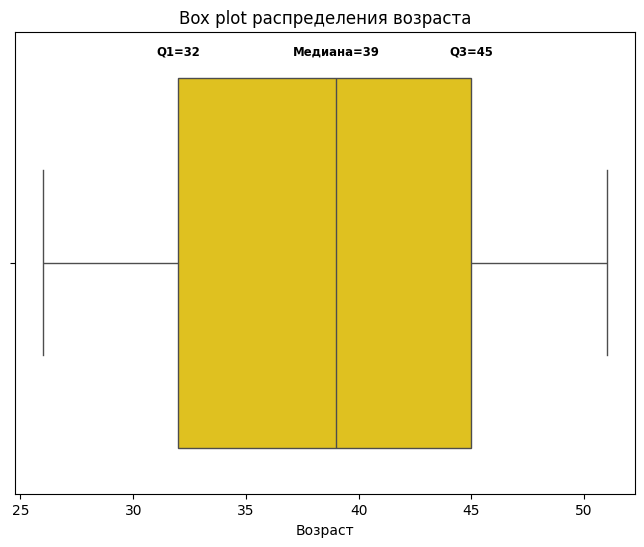

In [ ]:
# Статистика по возрасту
print("Описательная статистика по возрасту:")
print(df['age'].describe())

# Проверка на выбросы с помощью Box Plot
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x=df['age'], color='#FFD700') # Используем золотистый цвет
plt.title('Box plot распределения возраста')
plt.xlabel('Возраст')

# Добавление аннотаций для медианы и квартилей
median = df['age'].median()
q1 = df['age'].quantile(0.25)
q3 = df['age'].quantile(0.75)

# Позиционируем аннотации над соответствующими линиями box plot
plt.text(median, ax.get_ylim()[1] * 0.9, f'Медиана={median:.0f}', horizontalalignment='center', size='small', color='black', weight='semibold')
plt.text(q1, ax.get_ylim()[1] * 0.9, f'Q1={q1:.0f}', horizontalalignment='center', size='small', color='black', weight='semibold')
plt.text(q3, ax.get_ylim()[1] * 0.9, f'Q3={q3:.0f}', horizontalalignment='center', size='small', color='black', weight='semibold')


plt.show()

Медиана возраста составляет 39 лет, с первым квартилем (Q1) на уровне 32 лет и третьим квартилем (Q3) на уровне 45 лет. Размах данных (от минимального до максимального возраста) находится в пределах "усов" графика, что указывает на отсутствие явных выбросов в данных о возрасте в этом наборе. Распределение выглядит относительно симметричным вокруг медианы.

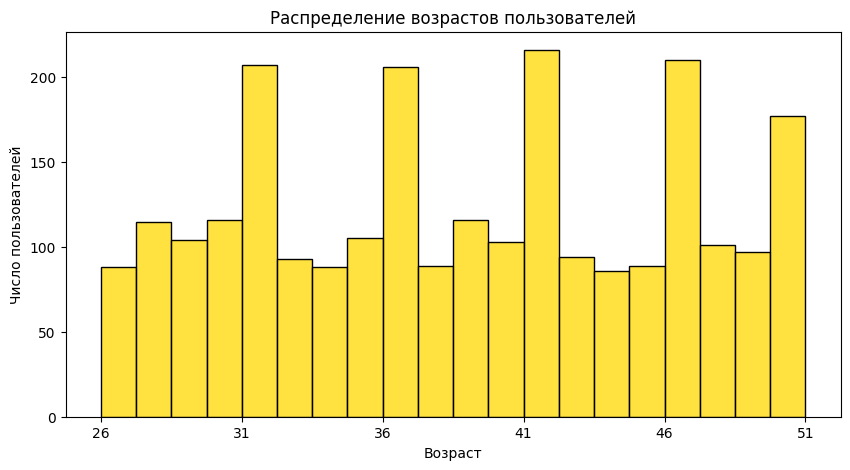

In [ ]:
# 1. Гистограмма распределения возрастов
plt.figure(figsize=(10,5))
sns.histplot(df['age'].dropna(), bins=20, kde=False, color='#FFD700')
plt.title('Распределение возрастов пользователей')
plt.xlabel('Возраст')
plt.ylabel('Число пользователей')
plt.xticks(range(int(df['age'].min()), int(df['age'].max())+1, 5))  # метки с шагом 5 лет
plt.show()

Распределение возрастов не является равномерным и имеет несколько пиков, указывающих на более высокую концентрацию пользователей в определенных возрастных диапазонах (около 32, 37, 42, 47 и 51 года).

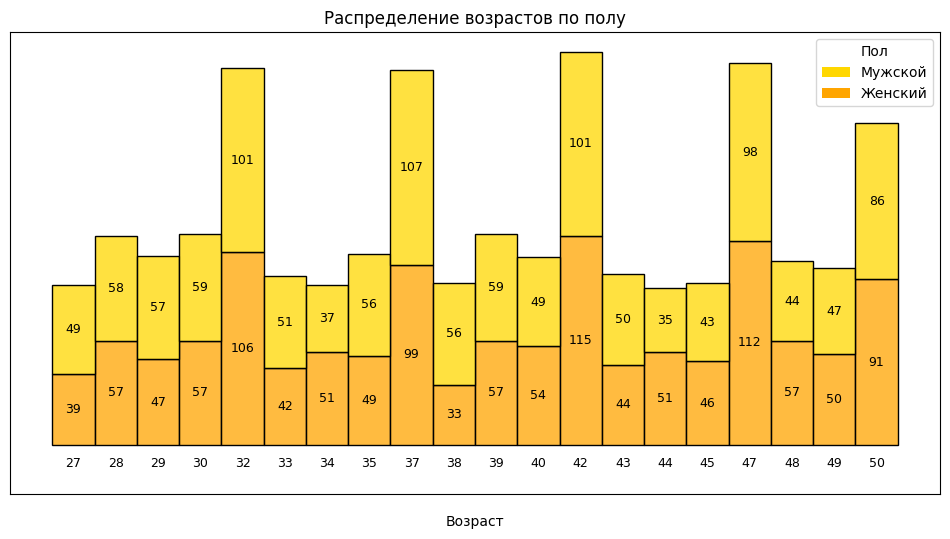

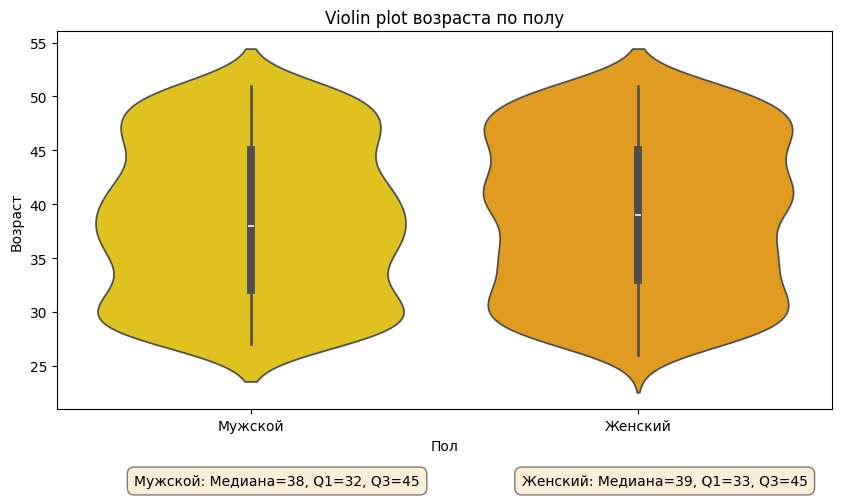

In [ ]:
# словарь для перевода
gender_translation = {
    'Male': 'Мужской',
    'Female': 'Женский'
}

# сопоставление цвета с оригинальными значениями пола
color_map = {
    'Male': '#FFD700',
    'Female': '#FFA500'
}

plt.figure(figsize=(12, 6))
# можно передавать palette как dict — тогда seaborn сам свяжет категории с цветами
ax = sns.histplot(data=df, x='age', hue='gender', multiple='stack', bins=20, palette=color_map)
plt.title('Распределение возрастов по полу')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')

plt.xticks([])

# подписи под бинами, с запасом по Y
n_gender, bins_gender = np.histogram(df['age'], bins=20)
ymin, ymax = ax.get_ylim()
if ymin >= 0:
    ax.set_ylim(-0.12 * ymax, ymax)
for i in range(len(bins_gender) - 1):
    bin_center = (bins_gender[i] + bins_gender[i+1]) / 2
    if n_gender[i] > 0:
        ax.text(bin_center, -0.03 * ymax, f'{bin_center:.0f}',
                ha='center', va='top', color='black', fontsize=9)

ax.xaxis.labelpad = 15

# Определяем категории на основе уникальных значений в столбце 'gender'
categories = df['gender'].dropna().unique()

# Создаём ручные элементы легенды в нужном порядке
legend_handles = [Patch(facecolor=color_map[c], edgecolor='none') for c in categories]
legend_labels = [gender_translation.get(c, c) for c in categories]

# Гарантируем, что ncol >= 1
ncol = max(1, len(legend_handles))

# Размещаем легенду сверху справа
ax.legend(handles=legend_handles, labels=legend_labels, title='Пол',
          loc='upper right', frameon=True)

# Убираем метки и подписи на оси Y
ax.yaxis.set_visible(False)

# Добавляем значения на столбцы для каждого пола
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='center', fontsize=9)


# График Violin plot:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='gender', y='age', data=df, hue='gender', palette=['#FFD700', '#FFA500']) # Убираем legend=False для отображения легенды
plt.title('Violin plot возраста по полу')
plt.xlabel('Пол') # Переводим название оси "gender"
plt.ylabel('Возраст')

# Меняем метки на оси X на русский
# Устанавливаем метки оси X перед их переименованием
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([gender_translation.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()])


# Добавление аннотаций для медианы и квартилей под графиком
median_male = df[df['gender'] == 'Male']['age'].median()
q1_male = df[df['gender'] == 'Male']['age'].quantile(0.25)
q3_male = df[df['gender'] == 'Male']['age'].quantile(0.75)

median_female = df[df['gender'] == 'Female']['age'].median()
q1_female = df[df['gender'] == 'Female']['age'].quantile(0.25)
q3_female = df[df['gender'] == 'Female']['age'].quantile(0.75)

# Позиционируем текст под графиком с помощью transform=ax.transAxes и отрицательных y-координат
plt.text(0.1, -0.2, f'Мужской: Медиана={median_male:.0f}, Q1={q1_male:.0f}, Q3={q3_male:.0f}', horizontalalignment='left', fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5), transform=ax.transAxes)
plt.text(0.6, -0.2, f'Женский: Медиана={median_female:.0f}, Q1={q1_female:.0f}, Q3={q3_female:.0f}', horizontalalignment='left', fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5), transform=ax.transAxes)

plt.subplots_adjust(bottom=0.25) # Увеличиваем нижний отступ, чтобы аннотации не перекрывались
plt.show()

Распределение возрастов для обоих полов схоже, с похожими пиками и диапазонами возрастов. Медианный возраст у женщин (39 лет) немного выше, чем у мужчин (38 лет).

In [ ]:
# Создадим словарь для перевода названий типа подписки
subscription_translation = {
    'Basic': 'Базовая',
    'Premium': 'Премиум',
    'Standard': 'Стандартная'
}

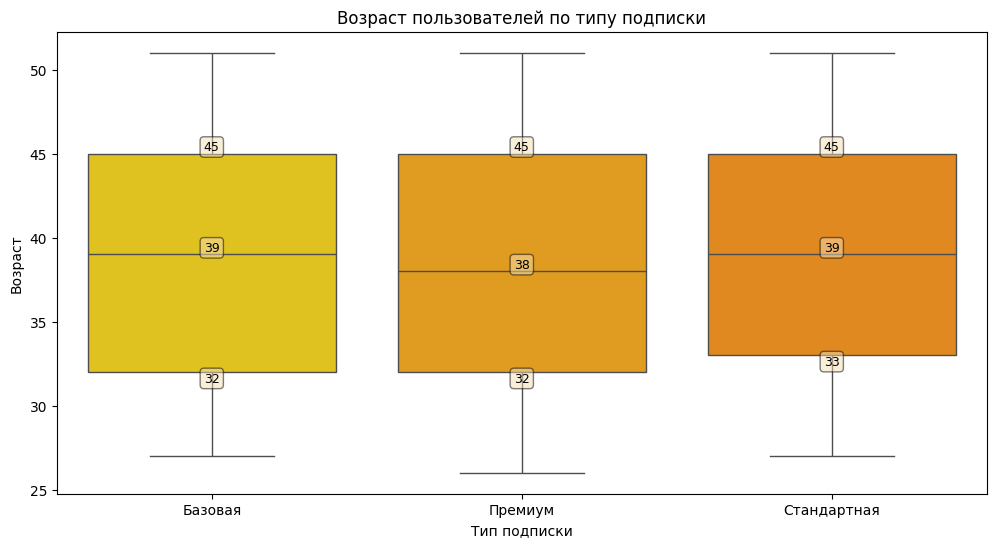

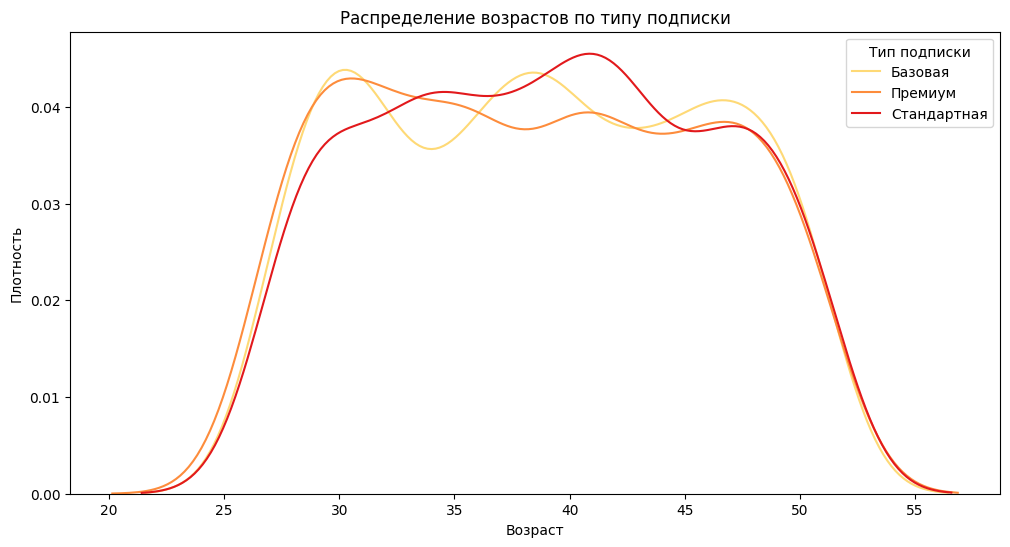

In [ ]:
# Анализ возраста по типу подписки (столбец 'subscriptionType')

plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='subscriptionType', y='age', data=df, hue='subscriptionType', palette=['#FFD700', '#FFA500', '#FF8C00'], legend=False) # Добавлен hue='subscriptionType' и legend=False
plt.title('Возраст пользователей по типу подписки')
plt.xlabel('Тип подписки')
plt.ylabel('Возраст')

# Переводим метки оси X
ax.set_xticks(ax.get_xticks()) # Устанавливаем метки оси X перед их переименованием
ax.set_xticklabels([subscription_translation.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()])


# Добавление аннотаций для медианы и квартилей по типу подписки
for i, sub_type in enumerate(df['subscriptionType'].unique()):
    subset_age = df[df['subscriptionType'] == sub_type]['age']
    median_sub = subset_age.median()
    q1_sub = subset_age.quantile(0.25)
    q3_sub = subset_age.quantile(0.75)
    plt.text(i, median_sub, f'{median_sub:.0f}', horizontalalignment='center', verticalalignment='bottom', color='black', fontsize=9, bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))
    plt.text(i, q1_sub, f'{q1_sub:.0f}', horizontalalignment='center', verticalalignment='top', color='black', fontsize=9, bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))
    plt.text(i, q3_sub, f'{q3_sub:.0f}', horizontalalignment='center', verticalalignment='bottom', color='black', fontsize=9, bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))

plt.show()

# Можно использовать и другой тип графика, например, распределение:
plt.figure(figsize=(12, 6))
# Используем палитру в желтой гамме с более различимыми цветами
colors = sns.color_palette("YlOrRd", n_colors=len(df['subscriptionType'].unique())) # Используем палитру YlOrRd (Yellow-Orange-Red)
for i, sub_type in enumerate(df['subscriptionType'].unique()):
    subset = df[df['subscriptionType'] == sub_type]
    # Применяем перевод к меткам легенды
    sns.kdeplot(subset['age'], label=subscription_translation.get(sub_type, sub_type), color=colors[i])
plt.title('Распределение возрастов по типу подписки')
plt.xlabel('Возраст')
plt.ylabel('Плотность')
# Убираем перевод на русский для легенды по типу подписки
plt.legend(title='Тип подписки')

plt.show()

Медианный возраст и возраст средних 50% пользователей очень схожи для всех трёх типов подписки. Распределение возрастов пользователей существенно не различается между различными типами подписки.

## Изучение пола пользователя

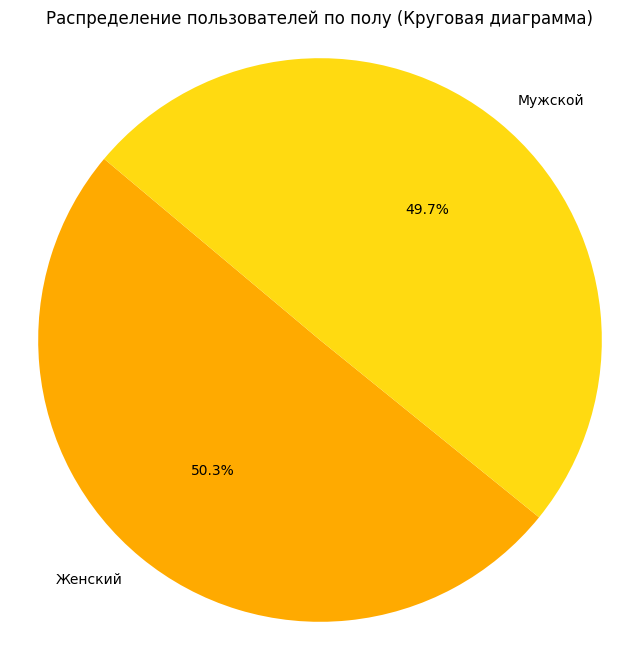

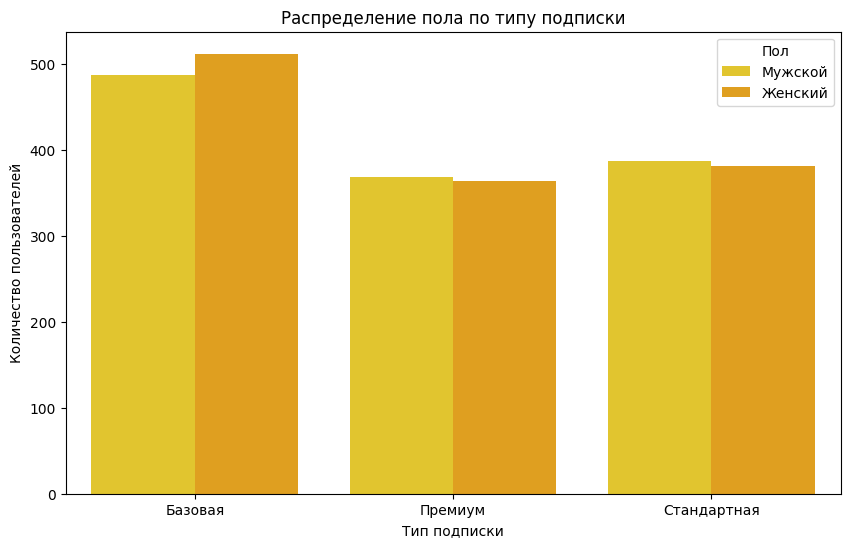

In [ ]:
# Создадим словарь для перевода названий пола
gender_translation = {
    'Male': 'Мужской',
    'Female': 'Женский'
}

# 1.  Круговая диаграмма (Pie chart) распределения по полу
plt.figure(figsize=(8, 8))
gender_counts = df['gender'].value_counts()
# Применяем перевод к меткам круговой диаграммы
translated_labels = [gender_translation.get(label, label) for label in gender_counts.index]
# Меняем порядок цветов в палитре
colors = sns.color_palette('Wistia', n_colors=len(gender_counts))
colors = [colors[1], colors[0]] # Меняем местами цвета для Male и Female
plt.pie(gender_counts.values, labels=translated_labels, autopct='%1.1f%%', startangle=140, colors=colors) # Используем измененный порядок цветов
plt.title('Распределение пользователей по полу (Круговая диаграмма)')
plt.axis('equal') # Убедимся, что круговая диаграмма круглая
plt.show()

# 2. Дополнительно:  Если есть другие категориальные переменные, можно посмотреть
#    распределение пола в зависимости от этих переменных.  Пример:

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='subscriptionType', hue='gender', data=df, palette='Wistia')
plt.title('Распределение пола по типу подписки')
plt.xlabel('Тип подписки')
plt.ylabel('Количество пользователей')
# Переводим метки легенды
handles, labels = ax.get_legend_handles_labels()
translated_labels = [gender_translation.get(label, label) for label in labels]
ax.legend(handles, translated_labels, title='Пол')

# Переводим метки оси X для второго графика
ax.set_xticks(ax.get_xticks()) # Устанавливаем метки оси X перед их переименованием
ax.set_xticklabels([subscription_translation.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()])

plt.show()

Число мужчин и женщин среди пользователей примерно одинаково.

Распределение мужчин и женщин по типам подписки схоже, что указывает на отсутствие сильной зависимости между полом и выбранным типом подписки.

## Изучение распределения пользователей по девайсам

In [ ]:
# Создадим словарь для перевода названий девайсов
device_translation = {
    'Laptop': 'Ноутбук',
    'Tablet': 'Планшет',
    'Smartphone': 'Смартфон',
    'Smart TV': 'Smart TV'
}

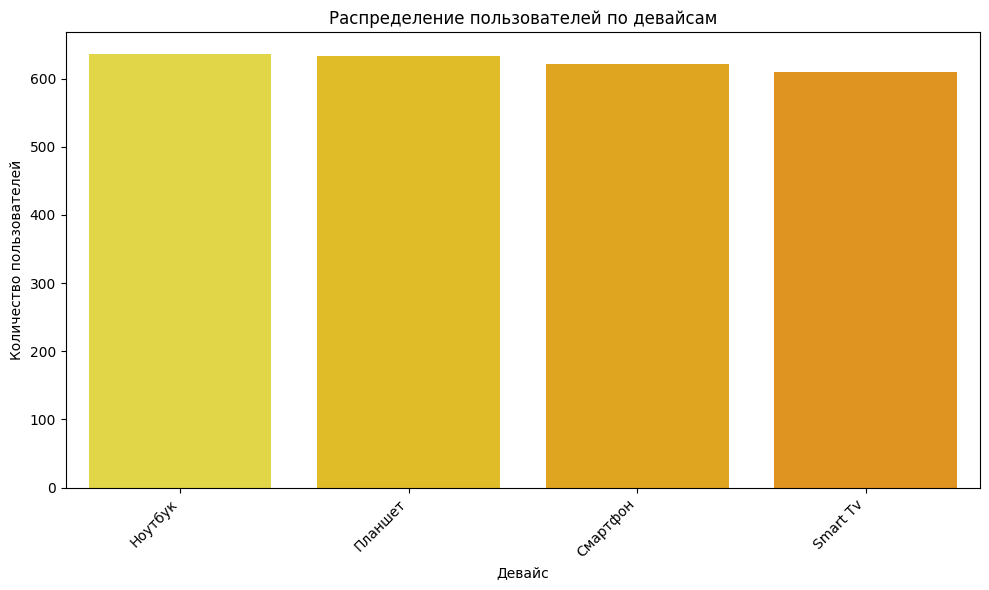

In [ ]:
# 1. Столбчатая диаграмма (Bar chart) распределения девайсов
plt.figure(figsize=(10, 6))
device_counts = df['device'].value_counts()
ax1 = sns.barplot(x=device_counts.index, y=device_counts.values, palette='Wistia', hue=device_counts.index, legend=False) # Используем палитру Wistia, добавлено hue и legend=False
plt.title('Распределение пользователей по девайсам')
plt.xlabel('Девайс')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45, ha='right') # Поворачиваем подписи по оси X для лучшей читаемости
# Применим перевод к меткам на оси X для первого графика
ax1.set_xticks(ax1.get_xticks()) # Устанавливаем метки оси X перед их переименованием
ax1.set_xticklabels([device_translation.get(label.get_text(), label.get_text()) for label in ax1.get_xticklabels()])
plt.tight_layout()
plt.show()

Количество пользователей, использующих различные типы устройств (ноутбуки, планшеты, смартфоны, Smart TV) распределено достаточно равномерно.

## Изучение типа подписки пользователей

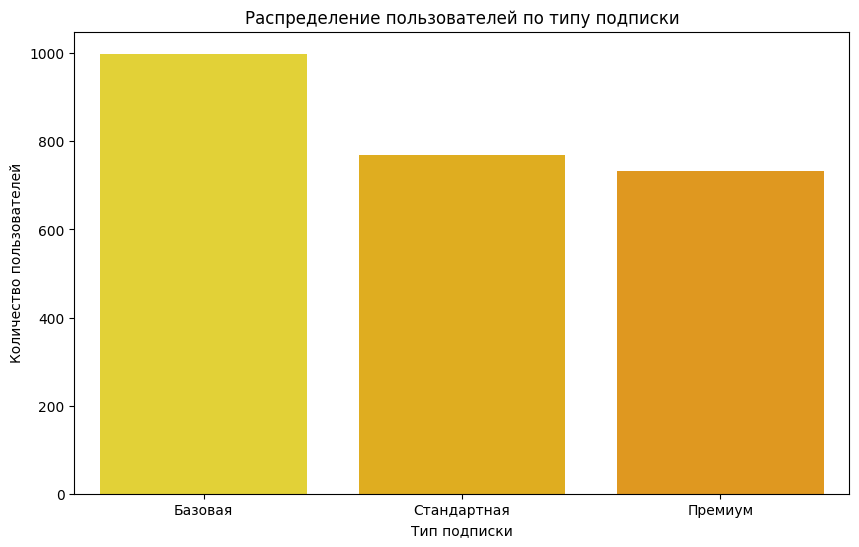

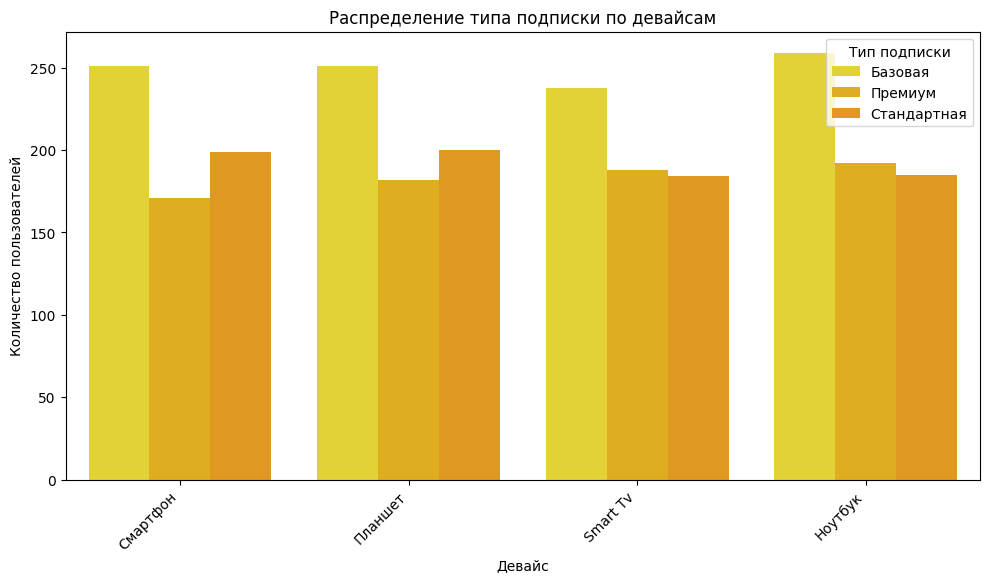

In [ ]:
# Столбчатая диаграмма (Bar chart) распределения по типу подписки
plt.figure(figsize=(10, 6))
# Рассчитываем количество пользователей по типу подписки
subscription_counts = df['subscriptionType'].value_counts()
ax = sns.barplot(x=subscription_counts.index, y=subscription_counts.values, palette='Wistia', hue=subscription_counts.index, legend=False)
plt.title('Распределение пользователей по типу подписки')
plt.xlabel('Тип подписки')
plt.ylabel('Количество пользователей')
# Переводим метки оси X
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([subscription_translation.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()])
plt.show()

# Дополнительно: Распределение типа подписки по девайсам
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='device', hue='subscriptionType', data=df, palette='Wistia')
plt.title('Распределение типа подписки по девайсам')
plt.xlabel('Девайс')
plt.ylabel('Количество пользователей')
# Переводим метки легенды
handles, labels = ax.get_legend_handles_labels()
translated_labels = [subscription_translation.get(label, label) for label in labels]
ax.legend(handles, translated_labels, title='Тип подписки')

plt.xticks(rotation=45, ha='right') # Поворачиваем подписи по оси X для лучшей читаемости
plt.tight_layout()
# Переводим метки оси X
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([device_translation.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()])
plt.show()

Наиболее популярным типом подписки является Базовая (около 40%), за ней следуют Стандартная (около 31%) и Премиум (около 29%). Распределение довольно сбалансировано, но Базовая подписка немного преобладает.

Распределение типа подписки по девайсам схоже для пользователей, использующих разные типы устройств (Ноутбук, Планшет, Смартфон, Smart TV). Это говорит о том, что тип устройства не оказывает сильного влияния на выбор типа подписки.

## Изучение локации пользователей

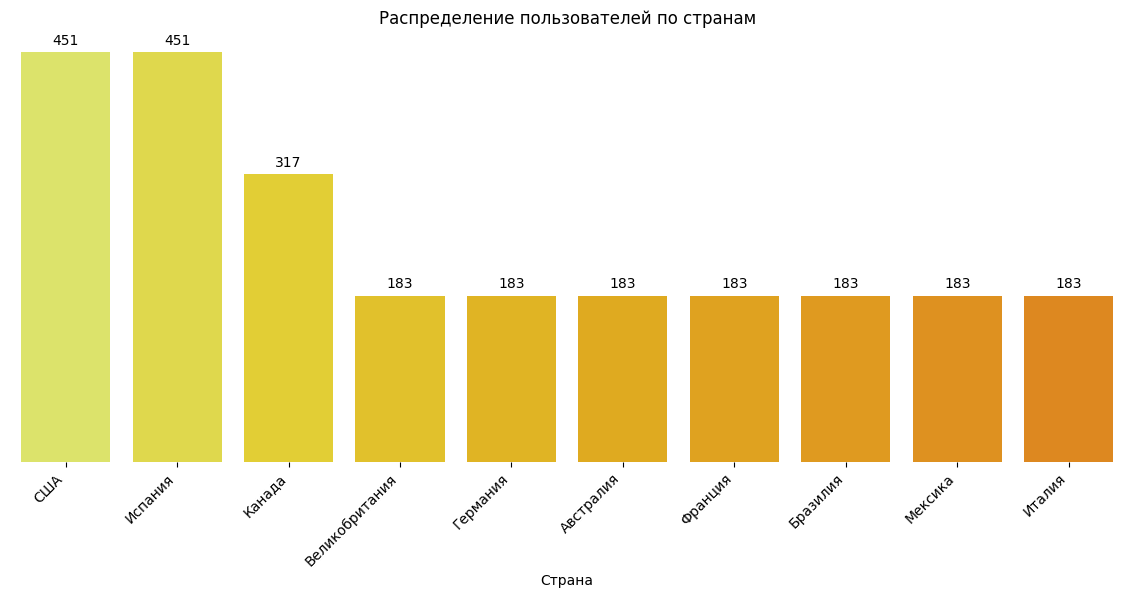

In [ ]:
# Создадим словарь для перевода названий стран
country_translation = {
    'United States': 'США',
    'Canada': 'Канада',
    'United Kingdom': 'Великобритания',
    'Germany': 'Германия',
    'Australia': 'Австралия',
    'France': 'Франция',
    'Brazil': 'Бразилия',
    'Mexico': 'Мексика',
    'Spain': 'Испания',
    'Italy': 'Италия'
}

# 1. Столбчатая диаграмма распределения пользователей по странам
plt.figure(figsize=(12, 6))
country_counts = df['country'].value_counts()
ax = sns.barplot(x=country_counts.index, y=country_counts.values, palette='Wistia', hue=country_counts.index, legend=False)
plt.title('Распределение пользователей по странам')
plt.xlabel('Страна')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45, ha='right') # Поворачиваем подписи по оси X для лучшей читаемости
plt.tight_layout()

# Explicitly set ticks before setting tick labels to avoid the UserWarning
ax.set_xticks(ax.get_xticks())
# Применим перевод к меткам на оси X
ax.set_xticklabels([country_translation.get(tick.get_text(), tick.get_text()) for tick in ax.get_xticklabels()])

# Добавляем значения количества пользователей сверху на столбцах
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5, f'{int(height)}', ha='center', va='bottom')

# Uбираем линии сетки
# plt.grid(axis='y', alpha=0.5)

# Делаем ось Y невидимой
ax.yaxis.set_visible(False)

# Убираем рамку
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.show()

Пользователи распределены по нескольким странам, при этом наибольшее число пользователей находится в США, Испании и Канаде.

## Динамика привлечения пользователей

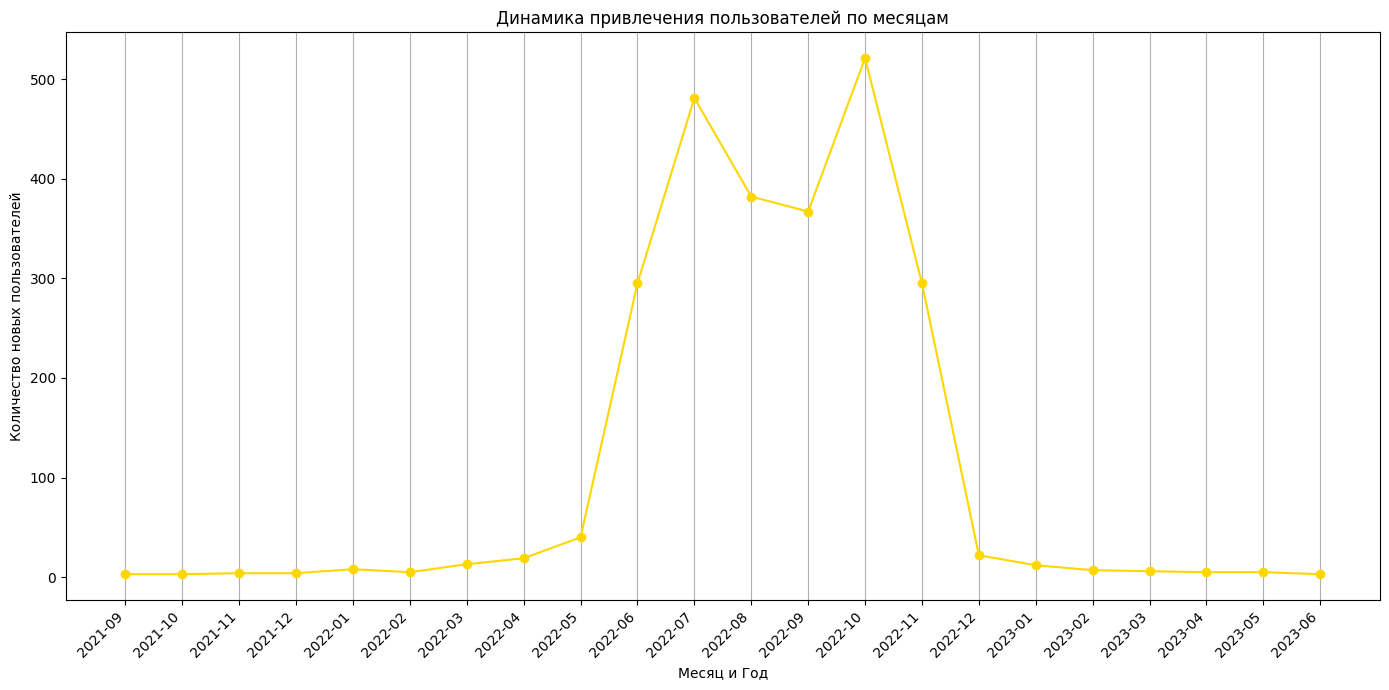

In [ ]:
# Динамика привлечения пользователей на основе данных Join date

# Извлечем месяц и год из Join Date
df['joinMonthYear'] = df['joinDate'].dt.to_period('M')

# Сгруппируем по месяцу и посчитаем Количество пользователей
monthly_join_counts = df['joinMonthYear'].value_counts().sort_index()

# Преобразуем индекс в строку для построения графика
monthly_join_counts.index = monthly_join_counts.index.astype(str)

# Построим линейный график динамики привлечения пользователей
plt.figure(figsize=(14, 7))
plt.plot(monthly_join_counts.index, monthly_join_counts.values, marker='o', linestyle='-', color='#FFD700') # Используем золотистый цвет и маркеры
plt.title('Динамика привлечения пользователей по месяцам')
plt.xlabel('Месяц и Год')
plt.ylabel('Количество новых пользователей')
plt.xticks(rotation=45, ha='right') # Поворачиваем подписи по оси X для лучшей читаемости
plt.grid(axis='x') # Отображаем только вертикальные линии сетки
plt.tight_layout()
plt.show()

Во второй половине 2022 года наблюдался рост привлечения новых пользователей с пиками в июле и октябре, что может быть связано с маркетинговыми акциями или другими факторами.

## Динамика выручки сервиса

   userId  subscriptionDurationMonths  totalRevenue
0       1                          18           180
1       2                          22           330
2       3                           5            60
3       4                          12           144
4       5                           2            20


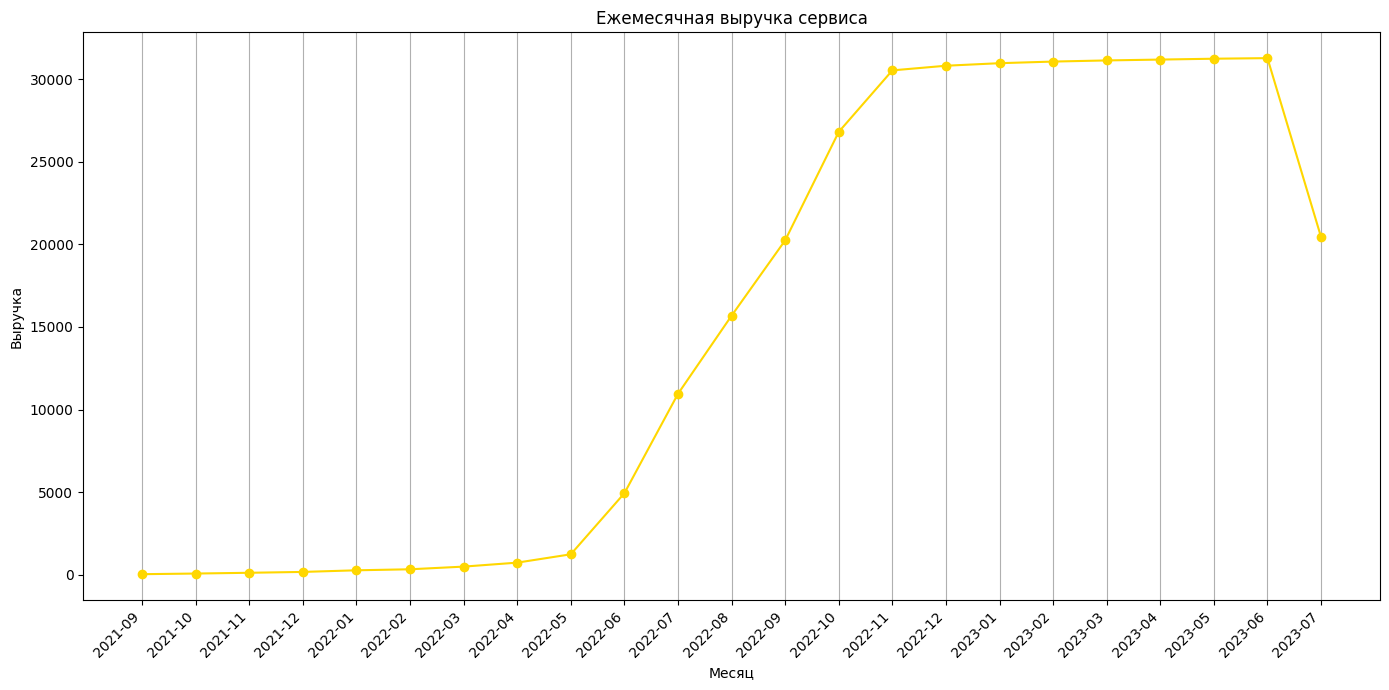

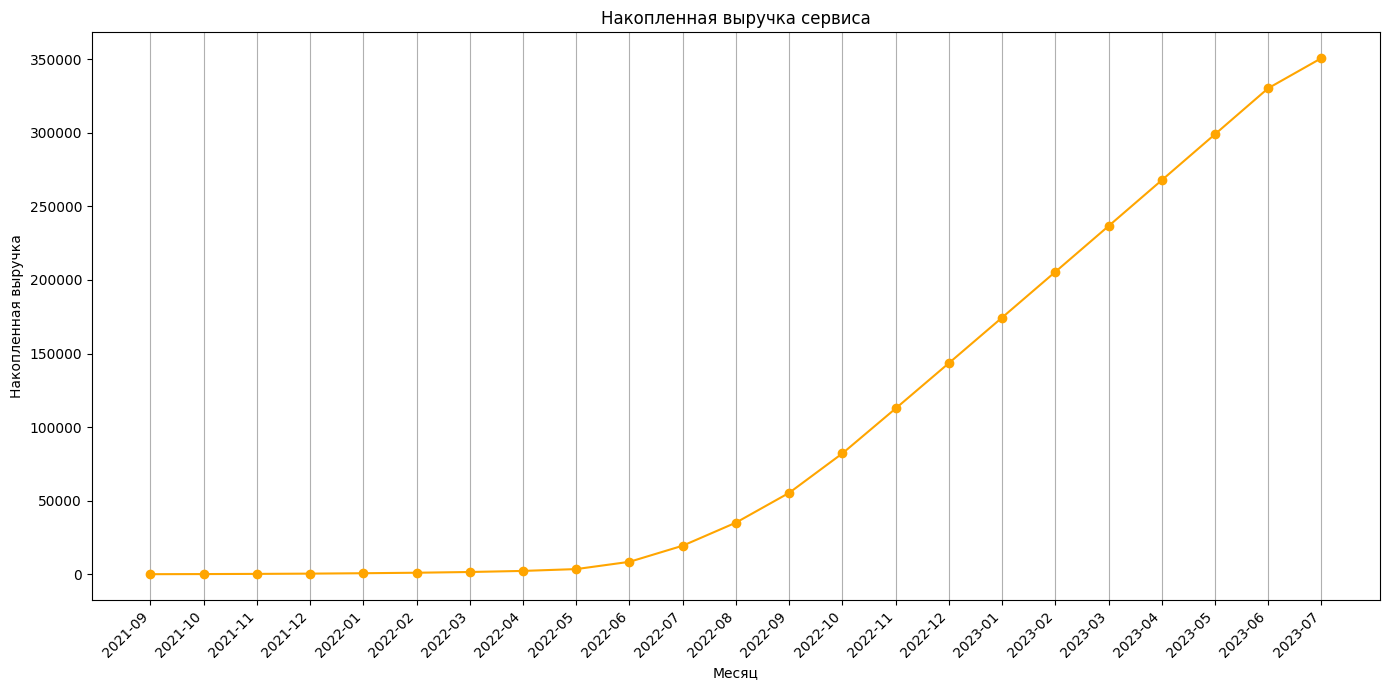

In [ ]:
# Расчёт длительности подписки в месяцах (включительно)
def months_inclusive(start, end):
    return (end.dt.year - start.dt.year) * 12 + (end.dt.month - start.dt.month) + 1

df['subscriptionDurationMonths'] = months_inclusive(df['joinDate'], df['lastPaymentDate']).clip(lower=0)

# === Расчёт накопленной выручки по каждому пользователю ===
df['totalRevenue'] = df['monthlyRevenue'] * df['subscriptionDurationMonths']

print(df[['userId', 'subscriptionDurationMonths', 'totalRevenue']].head())
# Найдем минимальную и максимальную дату в данных
min_date = df['joinDate'].min()
max_date = df['lastPaymentDate'].max()

# Создадим временной ряд по месяцам от минимальной до максимальной даты
all_months = pd.period_range(min_date.to_period('M'), max_date.to_period('M'), freq='M')

# Для каждого месяца рассчитаем, сколько активных пользователей приносили доход
# Это сложная задача, так как нужно отслеживать активность каждого пользователя по месяцам.
# Предположим, что пользователи активны с Join Date до Last Payment Date.

monthly_revenue_sum = []
for month in all_months:
    # Найдем пользователей, которые были активны в этом месяце
    # Активен, если Join Date <= конец месяца AND Last Payment Date >= начало месяца
    active_users_in_month = df[
        (df['joinDate'].dt.to_period('M') <= month) &
        (df['lastPaymentDate'].dt.to_period('M') >= month)
    ]
    # Суммируем ежемесячный доход этих пользователей за этот конкретный месяц.
    # Если Monthly_Revenue - это ежемесячный доход, то просто суммируем его.
    monthly_revenue_sum.append({'month': month, 'revenue': active_users_in_month['monthlyRevenue'].sum()})

monthly_revenue_df = pd.DataFrame(monthly_revenue_sum)
monthly_revenue_df['month'] = monthly_revenue_df['month'].astype(str) # Преобразуем Period в строку для графика
monthly_revenue_df['cumulativeRevenue'] = monthly_revenue_df['revenue'].cumsum()

# Построим график динамики ежемесячной выручки
plt.figure(figsize=(14, 7))
plt.plot(monthly_revenue_df['month'], monthly_revenue_df['revenue'], marker='o', linestyle='-', color='#FFD700')
plt.title('Ежемесячная выручка сервиса')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Построим график динамики накопленной выручки
plt.figure(figsize=(14, 7))
plt.plot(monthly_revenue_df['month'], monthly_revenue_df['cumulativeRevenue'], marker='o', linestyle='-', color='#FFA500')
plt.title('Накопленная выручка сервиса')
plt.xlabel('Месяц')
plt.ylabel('Накопленная выручка')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

На основании графиков ежемесячной и накопленной выручки можно сделать следующие выводы:

*   **Ежемесячная выручка сервиса**: После длительного периода роста и стабилизации на высоком уровне (с ноября 2022 г. июнь 2023 г.) ежемесячная выручка существенно снизилась.
*   **Накопленная выручка сервиса**: График накопленной выручки демонстрирует стабильный рост с течением времени. С июля 2022 года наблюдался более быстрый рост накопленной выручки.

## Определение самой платежеспособной группы клиентов по возрасту

Максимальный возраст: 51
Границы корзин: [0, 25, 35, 45, 55, 65, 100]
Суммарная выручка по возрастным группам:
ageGroup
35-44    139505
25-34    128872
45-54     82391
0-24          0
55-64         0
65+           0
Name: totalRevenue, dtype: int64


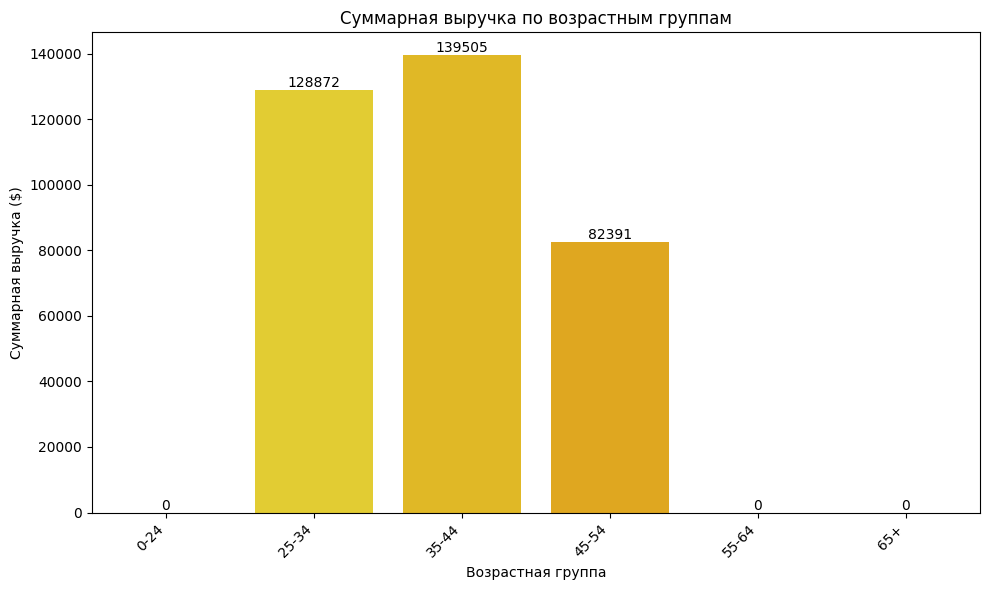

In [ ]:
# Определим границы возрастных корзин
age_bins = [0, 25, 35, 45, 55, 65, 100] # Устанавливаем верхнюю границу последней корзины на 100
age_labels = ['0-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Добавим вывод для отладки
print(f"Максимальный возраст: {df['age'].max()}")
print(f"Границы корзин: {age_bins}")


# Создадим новый столбец с возрастными корзинами
df['ageGroup'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=True, include_lowest=True) # Используем right=True и include_lowest=True

# Убедимся, что столбец с общим доходом создан (из предыдущего шага)
if 'totalRevenue' not in df.columns:
    # Если столбец totalRevenue еще не создан, рассчитаем его
    df['subscriptionDurationMonths'] = ((df['lastPaymentDate'] - df['joinDate']).dt.days / 30.44).round().astype(int) + 1
    df['totalRevenue'] = df['monthlyRevenue'] * df['subscriptionDurationMonths']

# Сгруппируем по возрастным корзинам и посчитаем суммарную выручку для каждой группы
revenue_by_age_group = df.groupby('ageGroup', observed=False)['totalRevenue'].sum().sort_values(ascending=False)

# Выведем результат
print("Суммарная выручка по возрастным группам:")
print(revenue_by_age_group)

# Определим самую платежеспособную группу
most_profitable_age_group = revenue_by_age_group.index[0]
highest_revenue = revenue_by_age_group.values[0]

# Визуализация суммарной выручки по возрастным группам
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=revenue_by_age_group.index, y=revenue_by_age_group.values, palette='Wistia', hue=revenue_by_age_group.index, legend=False)
plt.title('Суммарная выручка по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Суммарная выручка ($)') # Добавляем символ валюты
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Добавляем значения количества пользователей сверху на столбцах
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5, f'{int(height)}', ha='center', va='bottom')

plt.show()


Самая платежеспособная группа: 35-44 года с общей выручкой 139 505 $

## Корреляция числовых переменных

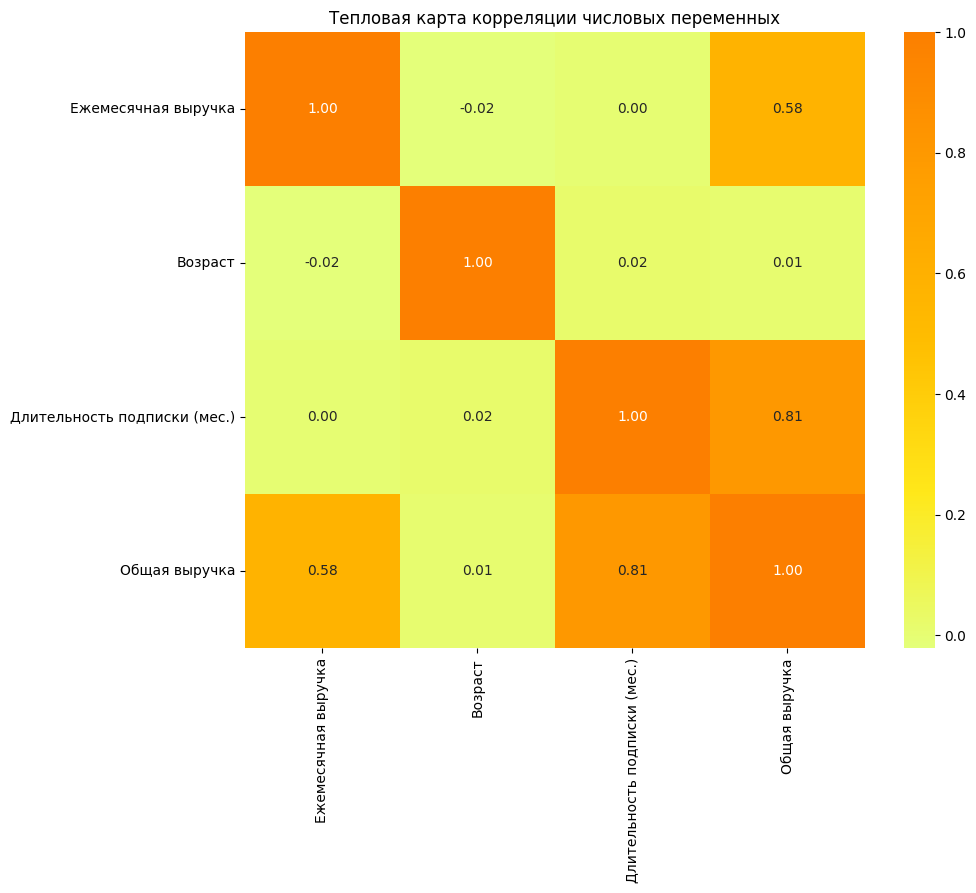

In [ ]:
# Выберем только числовые столбцы для расчета корреляции
numerical_df = df.select_dtypes(include=[np.number])

# Удалим столбец 'userId' из DataFrame, если он существует
if 'userId' in numerical_df.columns:
    numerical_df = numerical_df.drop('userId', axis=1)


# Рассчитаем матрицу корреляцииi
correlation_matrix = numerical_df.corr()

# Создадим словарь для перевода названий столбцов
column_translation = {
    'userId': 'ID пользователя',
    'monthlyRevenue': 'Ежемесячная выручка',
    'age': 'Возраст',
    'subscriptionDurationMonths': 'Длительность подписки (мес.)',
    'totalRevenue': 'Общая выручка'
}

# Переименуем столбцы и индексы матрицы корреляции для отображения на тепловой карте
correlation_matrix_translated = correlation_matrix.rename(columns=column_translation, index=column_translation)

# Построим тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_translated, annot=True, cmap='Wistia', fmt=".2f") # Используем палитру Wistia
plt.title('Тепловая карта корреляции числовых переменных')
plt.show()

 Самые сильные положительные корреляции наблюдаются между "Общей выручкой" и "Длительностью подписки", а также между "Общей выручкой" и "Ежемесячной выручкой". Это подчеркивает важность удержания пользователей (для увеличения длительности подписки) и, возможно, стимулирования выбора более дорогих типов подписки (для увеличения ежемесячной выручки) для роста общей выручки сервиса. Возраст пользователя не показал особой зависимости от финансовых показателей.

## Анализ зависимости типа подписки от группы возраста пользователя

Количество пользователей по возрастным группам и типам подписки:
subscriptionType  Basic  Premium  Standard
ageGroup                                  
0-24                  0        0         0
25-34               354      285       277
35-44               405      279       315
45-54               240      169       176
55-64                 0        0         0
65+                   0        0         0


<Figure size 1000x600 with 0 Axes>

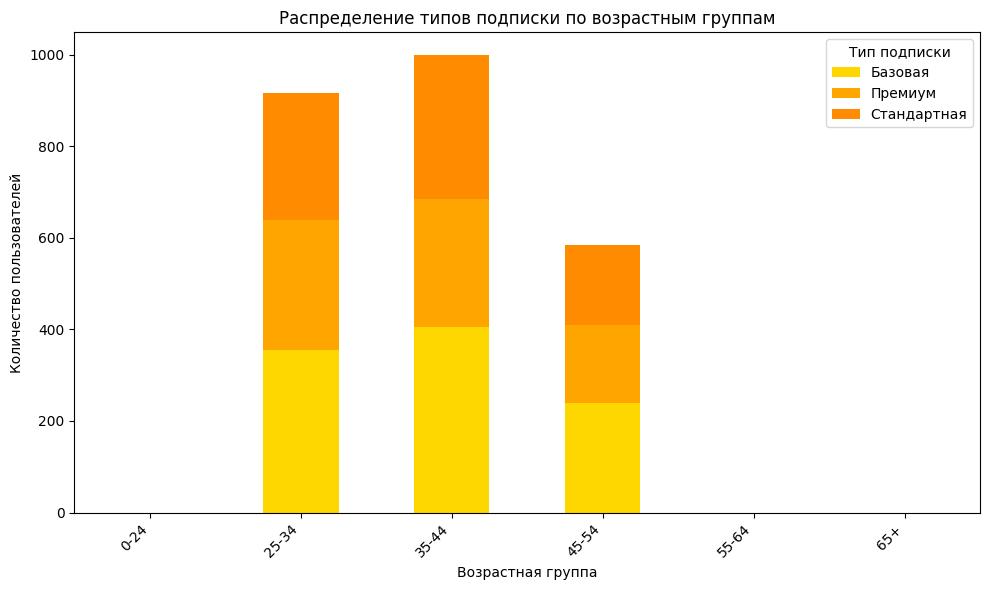


Процентное соотношение типов подписки по возрастным группам:
subscriptionType     Basic   Premium  Standard
ageGroup                                      
0-24                   NaN       NaN       NaN
25-34             0.386463  0.311135  0.302402
35-44             0.405405  0.279279  0.315315
45-54             0.410256  0.288889  0.300855
55-64                  NaN       NaN       NaN
65+                    NaN       NaN       NaN


<Figure size 1000x600 with 0 Axes>

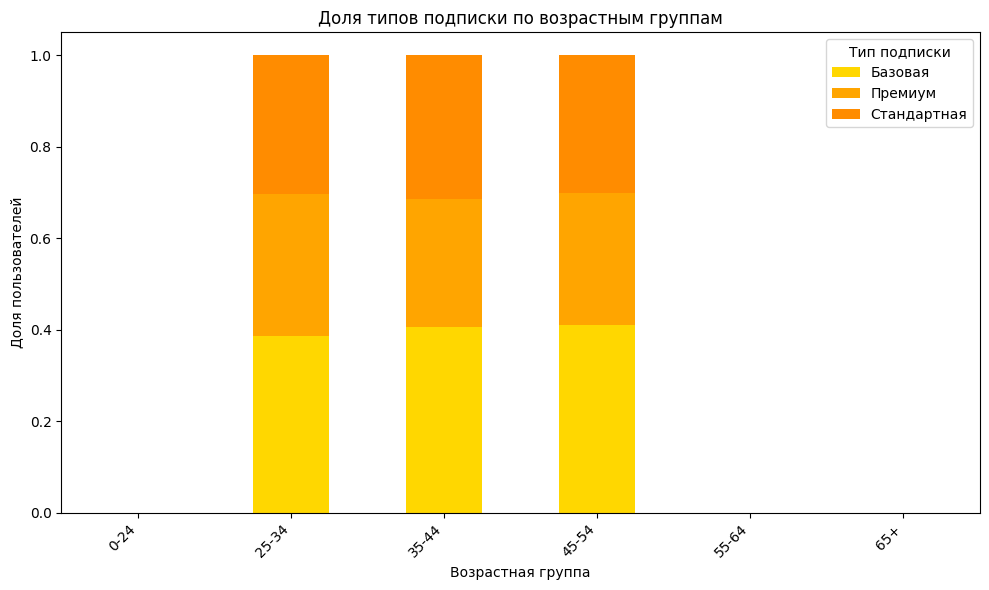


Доля премиум-подписки по возрастным группам (по убыванию):
ageGroup
25-34    0.311135
45-54    0.288889
35-44    0.279279
0-24          NaN
55-64         NaN
65+           NaN
Name: Premium, dtype: float64

Возрастная группа с наибольшей долей премиум-подписки: 25-34 (31.1%)


In [ ]:
# Создадим сводную таблицу с количеством пользователей по возрастным группам и типам подписки
age_group_subscription_counts = df.groupby('ageGroup', observed=False)['subscriptionType'].value_counts().unstack(fill_value=0)

# Выведем таблицу с количеством пользователей
print("Количество пользователей по возрастным группам и типам подписки:")
print(age_group_subscription_counts)

# Построим Stacked Bar Chart для визуализации распределения типов подписки по возрастным группам с помощью seaborn
plt.figure(figsize=(10, 6))
ax = age_group_subscription_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#FFD700', '#FFA500', '#FF8C00'])

plt.title('Распределение типов подписки по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45, ha='right')

# Переводим метки легенды
handles, labels = ax.get_legend_handles_labels()
translated_labels = [subscription_translation.get(label, label) for label in labels]
ax.legend(handles, translated_labels, title='Тип подписки')

plt.tight_layout()
plt.show()

# Дополнительно: Посмотрим процентное соотношение типов подписки внутри каждой возрастной группы
age_group_subscription_proportion = age_group_subscription_counts.divide(age_group_subscription_counts.sum(axis=1), axis=0)

# Выведем таблицу с процентным соотношением
print("\nПроцентное соотношение типов подписки по возрастным группам:")
print(age_group_subscription_proportion)

# Построим Stacked Bar Chart для визуализации процентного соотношения с помощью seaborn
plt.figure(figsize=(10, 6))
ax2 = age_group_subscription_proportion.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#FFD700', '#FFA500', '#FF8C00'])

plt.title('Доля типов подписки по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Доля пользователей')
plt.xticks(rotation=45, ha='right')

# Переводим метки легенды
handles2, labels2 = ax2.get_legend_handles_labels()
translated_labels2 = [subscription_translation.get(label, label) for label in labels2]
ax2.legend(handles2, translated_labels2, title='Тип подписки')


plt.tight_layout()
plt.show()

# Выделим группы, где соотношение премиум-подписки наибольшее
if 'Premium' in age_group_subscription_proportion.columns:
    premium_proportion = age_group_subscription_proportion['Premium'].sort_values(ascending=False)
    print("\nДоля премиум-подписки по возрастным группам (по убыванию):")
    print(premium_proportion)

    print(f"\nВозрастная группа с наибольшей долей премиум-подписки: {premium_proportion.index[0]} ({premium_proportion.values[0]:.1%})")
else:
    print("\nСтолбец 'Premium' не найден в данных о подписках.")

Распределение типов подписки (Базовая, Стандартная, Премиум) достаточно схоже для возрастных групп 25-34, 35-44 и 45-54 лет, которые составляют основную часть пользователей. Это говорит о том, что возраст в этих диапазонах не является сильным фактором при выборе типа подписки. Группы 0-24, 55-64 и 65+ не имеют пользователей в данном наборе данных. Среди активных групп, доля премиум-подписки немного выше в группе 25-34 лет.

## Анализ зависимости ежемесячной выручки от типа устройства

Средняя ежемесячная выручка по типу устройства:
device
Tablet        12.592417
Laptop        12.569182
Smart Tv      12.483607
Smartphone    12.384863
Name: monthlyRevenue, dtype: float64


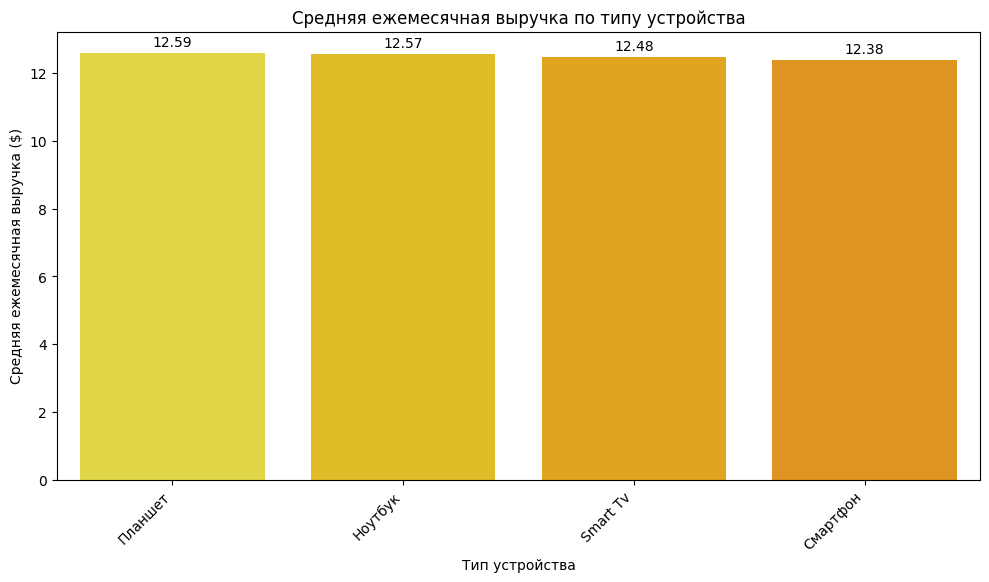

In [ ]:
# Группируем по типу устройства и считаем среднюю ежемесячную выручку
revenue_by_device = df.groupby('device')['monthlyRevenue'].mean().sort_values(ascending=False)

# Выводим результат
print("Средняя ежемесячная выручка по типу устройства:")
print(revenue_by_device)

# Визуализация средней ежемесячной выручки по типу устройства
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=revenue_by_device.index, y=revenue_by_device.values, palette='Wistia', hue=revenue_by_device.index, legend=False)
plt.title('Средняя ежемесячная выручка по типу устройства')
plt.xlabel('Тип устройства')
plt.ylabel('Средняя ежемесячная выручка ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Применим перевод к меткам на оси X
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([device_translation.get(tick.get_text(), tick.get_text()) for tick in ax.get_xticklabels()])

# Добавляем значения средней выручки сверху на столбцах
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1, f'{height:.2f}', ha='center', va='bottom')

plt.show()

Анализ средней ежемесячной выручки по типам устройств показывает, что различия между ними минимальны. Это говорит о том, что тип устройства не оказывает существенного влияния на ежемесячный доход, приносимый пользователем.

## Зависимость типа подписки от страны пользователя

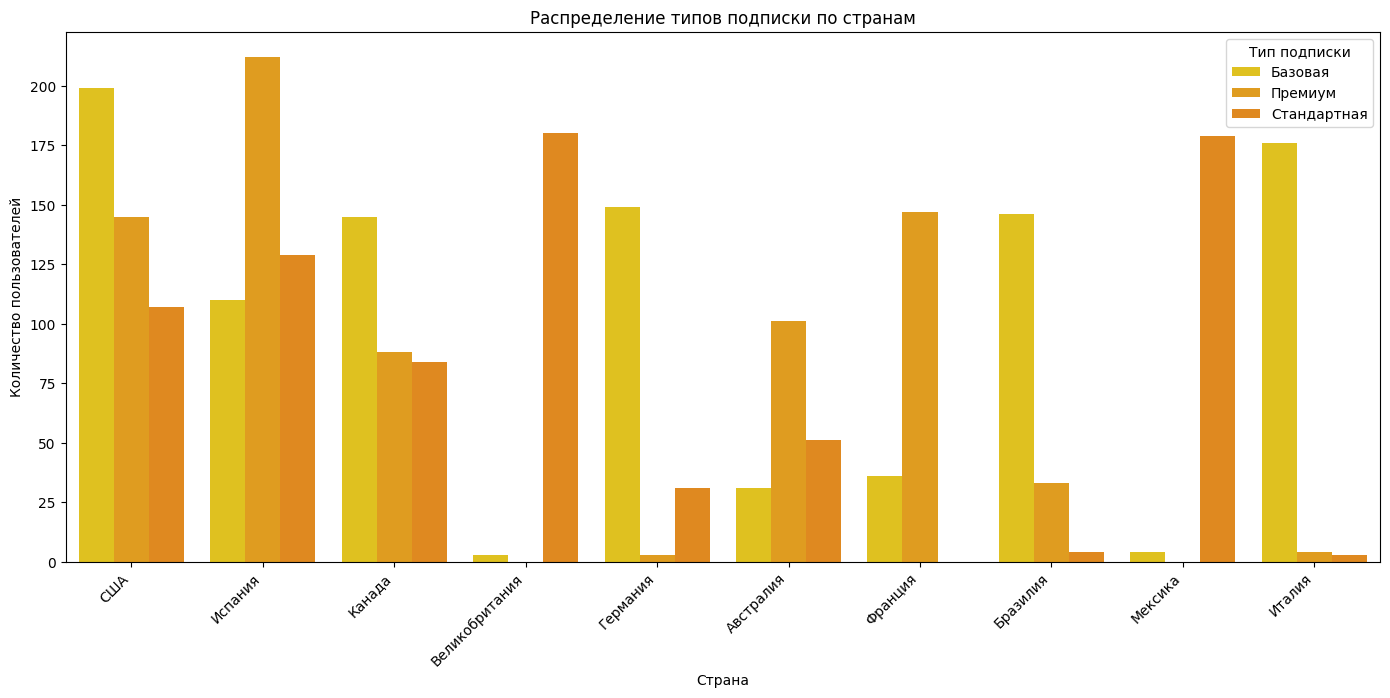

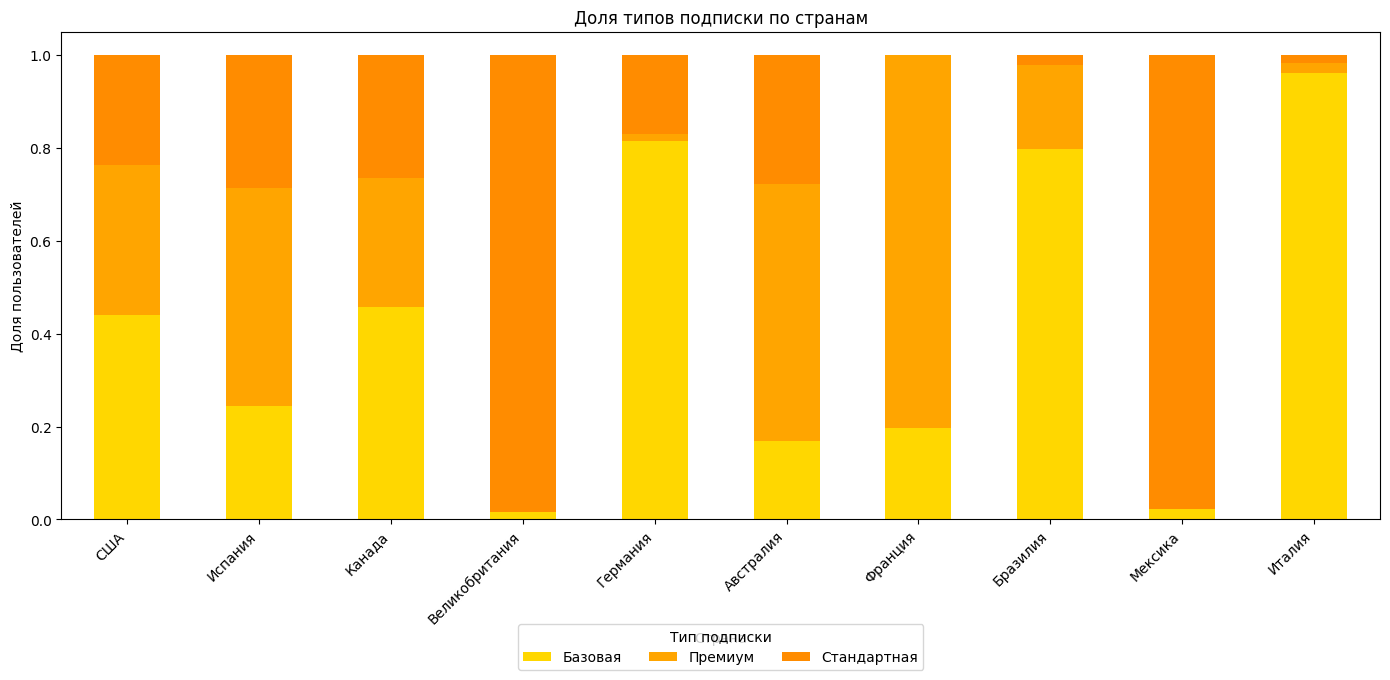

In [ ]:
# Используем countplot для визуал изации распределения типов подписки по странам
plt.figure(figsize=(14, 7))
country_order = df['country'].value_counts().index # Получаем порядок стран по убыванию количества пользователей
ax = sns.countplot(x='country', hue='subscriptionType', data=df, palette=['#FFD700', '#FFA500', '#FF8C00'], order=country_order) # Используем указанную палитру и задаем порядок стран
plt.title('Распределение типов подписки по странам')
plt.xlabel('Страна')
plt.ylabel('Количество пользователей')
# Переводим метки легенды
handles, labels = ax.get_legend_handles_labels()
translated_labels = [subscription_translation.get(label, label) for label in labels]
ax.legend(handles, translated_labels, title='Тип подписки')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Применим перевод к меткам на оси X
# Установим метки оси X перед их переименованием
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels([country_translation.get(tick.get_text(), tick.get_text()) for tick in ax.get_xticklabels()])

plt.show()

# Дополнительно можно посмотреть в процентном соотношении, используя crosstab и plot(kind='bar')
crosstab_country_sub = pd.crosstab(df['country'], df['subscriptionType'], normalize='index')
# Переиндексируем crosstab, чтобы порядок стран соответствовал country_order
crosstab_country_sub = crosstab_country_sub.reindex(country_order)
ax2 = crosstab_country_sub.plot(kind='bar', stacked=True, figsize=(14, 7), color=['#FFD700', '#FFA500', '#FF8C00'])
plt.title('Доля типов подписки по странам')
plt.xlabel('Страна')
plt.ylabel('Доля пользователей')
# plt.legend(title='Тип подписки') # Добавил заголовок легенды
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# Применим перевод к меткам на оси X второго графика
# Установим метки оси X перед их переименованием
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels([country_translation.get(tick.get_text(), tick.get_text()) for tick in ax2.get_xticklabels()])

# Переводим метки легенды для второго графика
handles2, labels2 = ax2.get_legend_handles_labels()
translated_labels2 = [subscription_translation.get(label, label) for label in labels2]
ax2.legend(handles2, translated_labels2, title='Тип подписки', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=len(translated_labels2))

# Увеличиваем нижний отступ для размещения легенды
plt.subplots_adjust(bottom=0.25)


plt.show()

На основании графиков распределения типов подписки по странам видно, что:

*   **Количество пользователей по странам**: Наибольшее количество пользователей находится в США и Испании, за ними следуют Канада, Великобритания, Германия, Австралия, Франция, Бразилия, Мексика и Италия. Распределение пользователей по странам неравномерное.
*   **Доля типов подписки по странам**: Распределение типов подписки значительно различается в зависимости от страны. Например, во Франции преобладает подписка Premium, в Великобритании и Мексике - Standard, а в Италии и Германии - Basic. Это говорит о сильной зависимости выбора типа подписки от страны проживания пользователя.

## Анализ зависимости ежемесячной выручки от продолжительности подписки

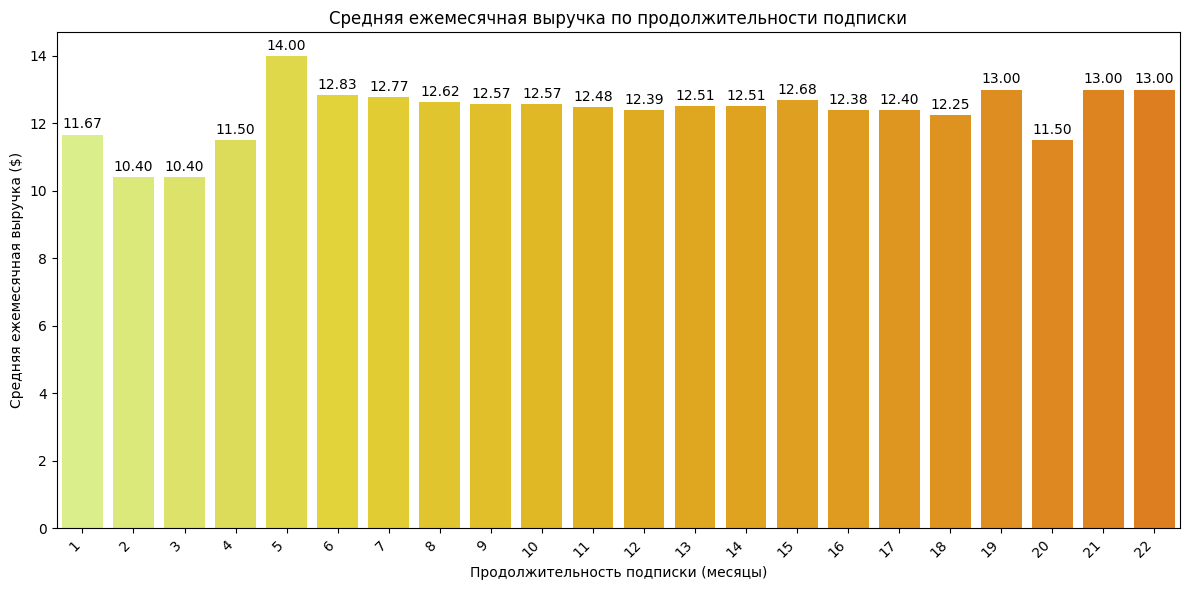

In [ ]:
# Анализ зависимости ежемесячной выручки от продолжительности подписки

# Группируем по продолжительности подписки в месяцах и считаем среднюю ежемесячную выручку
revenue_by_subscription_duration = df.groupby('subscriptionDurationMonths')['monthlyRevenue'].mean().reset_index()

# Визуализация средней ежемесячной выручки по продолжительности подписки
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='subscriptionDurationMonths', y='monthlyRevenue', data=revenue_by_subscription_duration, palette='Wistia', hue='subscriptionDurationMonths', legend=False)
plt.title('Средняя ежемесячная выручка по продолжительности подписки')
plt.xlabel('Продолжительность подписки (месяцы)')
plt.ylabel('Средняя ежемесячная выручка ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Добавляем значения средней выручки сверху на столбцах
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1, f'{height:.2f}', ha='center', va='bottom')

plt.show()

Нет явной возрастающей или убывающей тенденции в изменениях средней ежемесячной выручки по продолжительности подписки. Это может означать, что выбор типа подписки (и, как следствие уровень выручки) не зависит от того, как долго пользователь планирует пользоваться сервисом.

## Выводы по исследованию:

**Общая информация о пользователях:**

*   В наборе данных представлены 2500 уникальных пользователей.
*   Период данных охватывает активность пользователей с 05-09-2021 по 15-07-2023.
*   Соотношение мужчин и женщин среди пользователей практически равное.

**Возраст пользователей:**

*   Возраст пользователей варьируется от 26 до 51 года.
*   Медианный возраст составляет 39 лет.
*   Распределение возрастов не является равномерным, с пиками около 32, 37, 42, 47 и 51 года.
*   Статистически значимых различий в распределении возрастов по типу подписки не выявлено.

**Тип подписки:**

*   Наиболее популярный тип подписки - Basic (около 40%), далее Standard (около 31%) и Premium (около 29%).
*   Распределение типов подписки значительно различается в зависимости от страны.
*   Тип устройства и возраст не оказывают сильного влияния на выбор типа подписки.

**География пользователей:**

*   Наибольшее количество пользователей проживает в США и Испании.
*   Распределение пользователей по странам неравномерное.

**Динамика привлечения и выручки:**

*   Наблюдался значительный рост привлечения новых пользователей во второй половине 2022 года, с пиками в июле и октябре.
*   Ежемесячная выручка демонстрировала рост с мая 2022 по май 2023, но затем существенно снизилась.
*   Накопленная выручка стабильно растет с течением времени.

**Платежеспособность:**

*   Самая платежеспособная возрастная группа - 35-44 года.
*   Наибольшая доля Premium-подписок наблюдается в возрастной группе 25-34 лет.

**Корреляции:**

*   Существует сильная положительная корреляция между общей выручкой и длительностью подписки, а также между общей и ежемесячной выручкой.
*   Возраст и тип устройства практически не коррелируют с финансовыми показателями.

**Длительность подписки:**

*   Средняя ежемесячная выручка слабо зависит от продолжительности подписки.


# Рекомендации
1. **Повышение Выручки и Апгрейдов:**
   * Целевые кампании для 35-44 лет: активно продвигать Премиум-подписки среди самой платежеспособной группы (35-44 года), акцентируя внимание на качестве, семейном просмотре и количестве устройств.
   * Мотивирование Basic к Standard/Premium: разработать акции и персонализированные предложения для 40% пользователей с Basic подпиской, демонстрируя ценность апгрейда.
   * Расследование падения выручки: выявить причины снижения ежемесячной выручки после июня 2023 и разработать план по ее восстановлению.
2. **Географическая Стратегия:**
   * Капитализация успеха в Испании и Франции: изучить, что именно способствует высокой доле Премиум-подписок в этих странах, и применить успешные практики (маркетинг, контент, ценообразование) на других рынках, особенно в США и Канаде.
   * Укрепление основных рынков: продолжить инвестиции в локализованный контент и маркетинг в США, Испании, Канаде.
3. **Привлечение и Удержание:**
   * Изучение пиков привлечения: проанализировать кампании и контент, которые привели к росту пользователей в июле и октябре 2022, для воспроизведения успеха.
   * Фокус на удержание: учитывая замедление роста накопленной выручки, усилить программы по снижению оттока для всех сегментов.
4. **Контент и Персонализация:**
   * Контент для 32-45 лет: учитывая средний возраст пользователей, инвестировать в контент, который максимально релевантен этой ключевой демографической группе.